In [45]:
import os
import pickle
import scipy.stats as stats
import pymc3 as pm
import theano.tensor as tt
import numpy as np
import pylab as plt
from pymc3.variational.callbacks import CheckParametersConvergence
import theano
from theano.tensor.extra_ops import cumsum
from scipy.stats import poisson
import pandas as pd

[205 733]
[   0  205  733 1000]
[[0.1420578  0.24323379 0.27936525]]
(1000,)


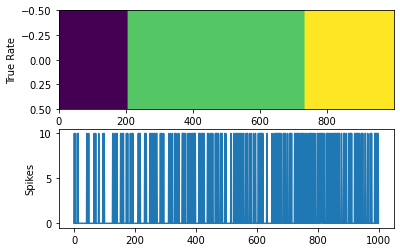

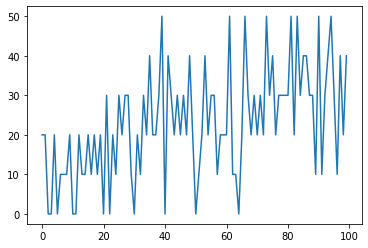

In [46]:
# Some poisson spiking
length = 1000
states = 3
nrns = 1
fit = int(2e5)
samples = 2000
idx = np.arange(length)

true_tau = np.cumsum(np.random.random(states))
true_tau /= np.max(true_tau)
true_tau *= length
true_tau = np.vectorize(np.int)(true_tau)
state_inds = np.concatenate([np.zeros((1)),true_tau])
state_inds = np.vectorize(np.int)(state_inds)
true_tau = true_tau[:-1]

true_lambda = np.random.random((nrns,states))

print(true_tau)
print(state_inds)
print(true_lambda)

true_r = np.zeros((nrns,length))
for num, val in enumerate(true_lambda.T):
    true_r[:,state_inds[num]:state_inds[num+1]] = val[:,np.newaxis]
  
data_vec = (np.random.random((nrns,length)) < true_r)*10
data_vec = data_vec.flatten()
time = np.arange(len(data_vec))
print(data_vec.shape)
#data_vec = np.random.poisson(true_r)

fig,ax = plt.subplots(2,1)
ax[0].imshow(true_r,aspect='auto')
ax[1].plot(time,data_vec)
ax[0].set_ylabel("True Rate")
ax[1].set_ylabel("Spikes")


bin_width = 10
sharp_data_vec = np.sum(data_vec.reshape((-1,bin_width)),axis=-1)
plt.figure()
plt.plot(sharp_data_vec)

In [47]:
def cp_design_mat_np(x, cps):
    return (0.5 * (1.0 + np.sign(np.tile(x[:,None], (1,len(cps))) - cps)))

def selector_mat_np(x, x_anchors):
    A = cp_design_mat_np(x, x_anchors[:-1])
    B = cp_design_mat_np(x, x_anchors[1:])
    return A-B

def return_line_np(x, x_anchors, y_anchors):
    x_diff = np.diff(x_anchors)
    y_diff = np.diff(y_anchors)
    dy_dx = y_diff/x_diff
    state_map = selector_mat_np(x, x_anchors)
    dy_dt = state_map.dot(dy_dx)
    y = np.cumsum(dy_dt) + y_anchors[0]
    return y

In [48]:
# 1 nrns - multiple trials model
max_len = 100
x = np.arange(max_len)
trials = 10
x_anchors_seed = np.array([ 0.        , 33.5, 66, 99.        ])#[0,33,66,100]
y_anchors_seed = np.array([30.4508939 , 100,  5.54195018, 15.978493  ])
x_jitter = (np.random.random(size = (trials, states-1))-1)*max_len/5
y_jitter = (np.random.random(size = (trials, states+1))-1)*40
x_anchors = np.tile(x_anchors_seed, (trials,1))
x_anchors[:,1:-1] += x_jitter
y_anchors = y_anchors_seed + y_jitter
x_anchors[x_anchors<0] = 0
y_anchors[y_anchors<0] = 0

In [49]:
smooth_rate = np.stack([return_line_np(x, x_anc, y_anc) for x_anc, y_anc in zip(x_anchors,y_anchors)])
smooth_rate[smooth_rate<0] = 0

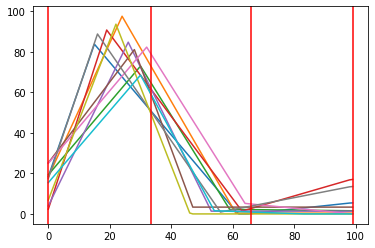

In [50]:
plt.plot(smooth_rate.T)
for i in x_anchors_seed:
    plt.axvline(i, color = 'red')

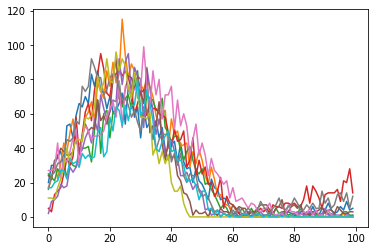

In [51]:
smooth_dat_vec = poisson.rvs(mu = smooth_rate)
plt.plot(smooth_dat_vec.T);

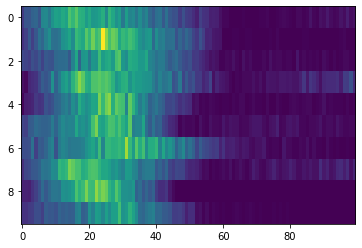

In [52]:
plt.imshow(smooth_dat_vec, aspect='auto')

In [145]:
# 2D functions
def cp_design_mat_np(x, cps):
    return (0.5 * (1.0 + np.sign(np.tile(x[:,None,None], (1,cps.shape[0], cps.shape[1])) - cps)))
    
def selector_mat_np(x, x_anchors):
    A = cp_design_mat_np(x, x_anchors[:,:-1])
    B = cp_design_mat_np(x, x_anchors[:,1:])
    return A-B

def return_line_np(x, x_anchors, y_anchors):
    x_diff = np.diff(x_anchors,axis=-1)
    y_diff = np.diff(y_anchors, axis=-1)
    dy_dx = y_diff/x_diff
    state_map = selector_mat_np(x, x_anchors).swapaxes(0,1)
    dy_dt = np.squeeze(np.stack([np.dot(x[None,:],y.T) for x,y in zip(dy_dx,state_map)]))
    y = np.cumsum(dy_dt,axis=-1) + y_anchors[:,0][:,None]
    return y

In [146]:
def cp_design_mat(x, cps):
    return (0.5 * (1.0 + tt.sgn(tt.tile(x[:,None,None], (1,cps.shape[0], cps.shape[1])) - cps)))

def selector_mat(x, x_anchors):
    A = cp_design_mat(x, x_anchors[:,:-1])
    B = cp_design_mat(x, x_anchors[:,1:])
    return A-B

def oneStep(i, vec1, vec2):
    """
    vec1 = dy_dx
    vec2 = state_map
    """
    return vec1[i][None,:].dot(vec2[i].T)

def return_line(x, x_anchors, y_anchors):
    """
    x_anchors = trials x states + 1
    y_anchors = trials x states + 1
    """
    #x_diff = tt.extra_ops.diff(x_anchors, axis=-1)
    #y_diff = tt.extra_ops.diff(y_anchors, axis=-1)
    x_diff =  x_anchors[:,1:] - x_anchors[:,:-1]
    y_diff =  y_anchors[:,1:] - y_anchors[:,:-1]
    dy_dx = y_diff/x_diff
    state_map = selector_mat(x, x_anchors)
    #result, updates = theano.scan(fn=oneStep, sequences=tt.arange(dy_dx.shape[0]), non_sequences=[dy_dx, state_map])
    #dy_dt = tt.extra_ops.squeeze(result)
    dy_dt = tt.sum(state_map * dy_dx[None,:,:],axis=2).T
    y = tt.cumsum(dy_dt,axis=-1) + y_anchors[:,0][:,None]
    return y 

In [137]:
# with pm.Model() as cont_model:
    
#     alpha = pm.HalfNormal('alpha', 3, shape = states)
#     delta = pm.Dirichlet('delta', alpha, shape = (trials, states))
#     min_anchor = np.tile(0, (trials,1))
#     x_anchors = tt.concatenate([min_anchor, tt.cumsum(delta,axis=-1)],axis=-1)
    
#     idx = np.arange(smooth_dat_vec.shape[-1])
#     tau = pm.Deterministic('tau',idx.min() + (idx.max() - idx.min()) * x_anchors)
    
#     # y_anchor priors
#     y_seed = pm.HalfNormal('y_seed', 30, shape = states+1, testval = np.arange(1,states+2)**3)
#     y_anchors = pm.HalfNormal('y_anchors', y_seed, shape = (trials,states+1))
    
#     # ===============================
#     #x_diff = tt.extra_ops.diff(x_anchors, axis=-1)
#     #y_diff = tt.extra_ops.diff(y_anchors, axis=-1)
#     x_diff =  tau[:,1:] - tau[:,:-1]
#     y_diff =  y_anchors[:,1:] - y_anchors[:,:-1]
#     dy_dx = y_diff/x_diff
#     cps1 = tau[:,:-1]
#     cps2 = tau[:,1:]
#     A=(0.5 * (1.0 + tt.sgn(tt.tile(x[:,None,None], (1,cps1.shape[0], cps1.shape[1])) - cps1)))
#     B=(0.5 * (1.0 + tt.sgn(tt.tile(x[:,None,None], (1,cps2.shape[0], cps2.shape[1])) - cps2)))
#     state_map = A-B
#     dy_dt = tt.sum(state_map * dy_dx[None,:,:],axis=2).T
#     y = tt.cumsum(dy_dt,axis=-1) + y_anchors[:,0][:,None]
#     # ===============================

#     lambda_ = pm.Deterministic('lambda_', y)
#     observation = pm.Poisson("obs", lambda_, observed=smooth_dat_vec)

In [242]:
with pm.Model() as test_model:
    alpha = pm.Gamma('alpha', 7,1, shape = states)
    delta = pm.Dirichlet('delta', alpha, shape = (trials, states), 
                         testval = np.tile(np.array(0.2), (trials, states)))
    trace = pm.sample()

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [delta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [235]:
with pm.Model() as cont_model:
    
    #alpha = pm.Gamma('alpha', 7,1, shape = states)
    #delta = pm.Dirichlet('delta', alpha, shape = (trials, states), 
    #                     testval = np.tile(np.array(0.2), (trials, states)))
    #min_anchor = tt.zeros((trials,1))
    #x_anchors = pm.math.concatenate([min_anchor, tt.cumsum(delta,axis=-1)],axis=1)
    
    alpha = pm.Gamma('alpha', 7,1, shape = states)
    delta = pm.Dirichlet('delta', alpha, shape = (trials, states), 
                         testval = np.tile(np.array(0.2), (trials, states)))
    min_anchor = tt.zeros((trials,1))
    x_anchors = pm.math.concatenate([min_anchor, tt.cumsum(delta,axis=-1)],axis=1)
    
    idx = np.arange(smooth_dat_vec.shape[-1])
    tau = pm.Deterministic('tau',idx.min() + (idx.max() - idx.min()) * x_anchors)
    
    # y_anchor priors
    y_seed = pm.HalfNormal('y_seed', 10, shape = states+1, testval = np.arange(1,states+2)**3)
    y_anchors = pm.HalfNormal('y_anchors', y_seed, shape = (trials,states+1))

    lambda_ = pm.Deterministic('lambda_', return_line(x, tau, y_anchors))
    observation = pm.Poisson("obs", lambda_, observed=smooth_dat_vec)

In [241]:
with cont_model:
    print(delta.tag.test_value)

[[0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]
 [0.33333333 0.33333333 0.33333333]]


In [217]:
#this_var = 'lambda_'
with cont_model:
    prior_checks = pm.sample_prior_predictive(samples=1000)#, var_names = [this_var])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 10 and the array at index 1 has size 1
Apply node that caused the error: Join(TensorConstant{1}, TensorConstant{(10, 1) of 0.0}, CumOp{-1, add}.0)
Toposort index: 1
Inputs types: [TensorType(int8, scalar), TensorType(float64, col), TensorType(float64, matrix)]
Inputs shapes: [(), (10, 1), (1, 3)]
Inputs strides: [(), (8, 8), (24, 8)]
Inputs values: [array(1, dtype=int8), 'not shown', array([[0.3433009 , 0.75428538, 1.        ]])]
Outputs clients: [[Elemwise{Mul}[(0, 1)](TensorConstant{(1, 1) of 99.0}, Join.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2858, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2886, in _run_cell
    return runner(coro)
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3063, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3254, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-214-61ac3e6f4e1d>", line 9, in <module>
    x_anchors = pm.math.concatenate([min_anchor, tt.cumsum(delta,axis=-1)],axis=1)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [200]:
prior_checks['tau']

array([[[17.7272186 , 65.89336304, 99.        ]],

       [[50.87939831, 60.66728975, 99.        ]],

       [[41.6097184 , 61.80647638, 99.        ]],

       ...,

       [[11.55186441, 36.22401392, 99.        ]],

       [[28.90865007, 65.61144949, 99.        ]],

       [[32.92179075, 80.54207547, 99.        ]]])

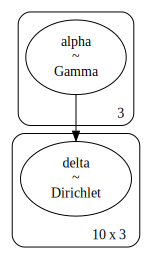

In [191]:
pm.model_to_graphviz(cont_model)

In [175]:
with cont_model:
    trace = pm.sample(step = pm.NUTS(),#target_accept=0.95),
                    tune = 2000, 
                      chains = 8, 
                      cores = 8)
    #trace = pm.sample(step = pm.Metropolis())
    #approx = pm.fit(n=100000, method=pm.ADVI('full-rank'))
    #trace = approx.sample(draws=20000)

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [y_anchors, y_seed, delta, alpha]


RuntimeError: Chain 0 failed.

In [130]:
#plt.plot(approx.hist[-5000:])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/arviz/plots/backends/matplotlib/pairplot.py:242: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


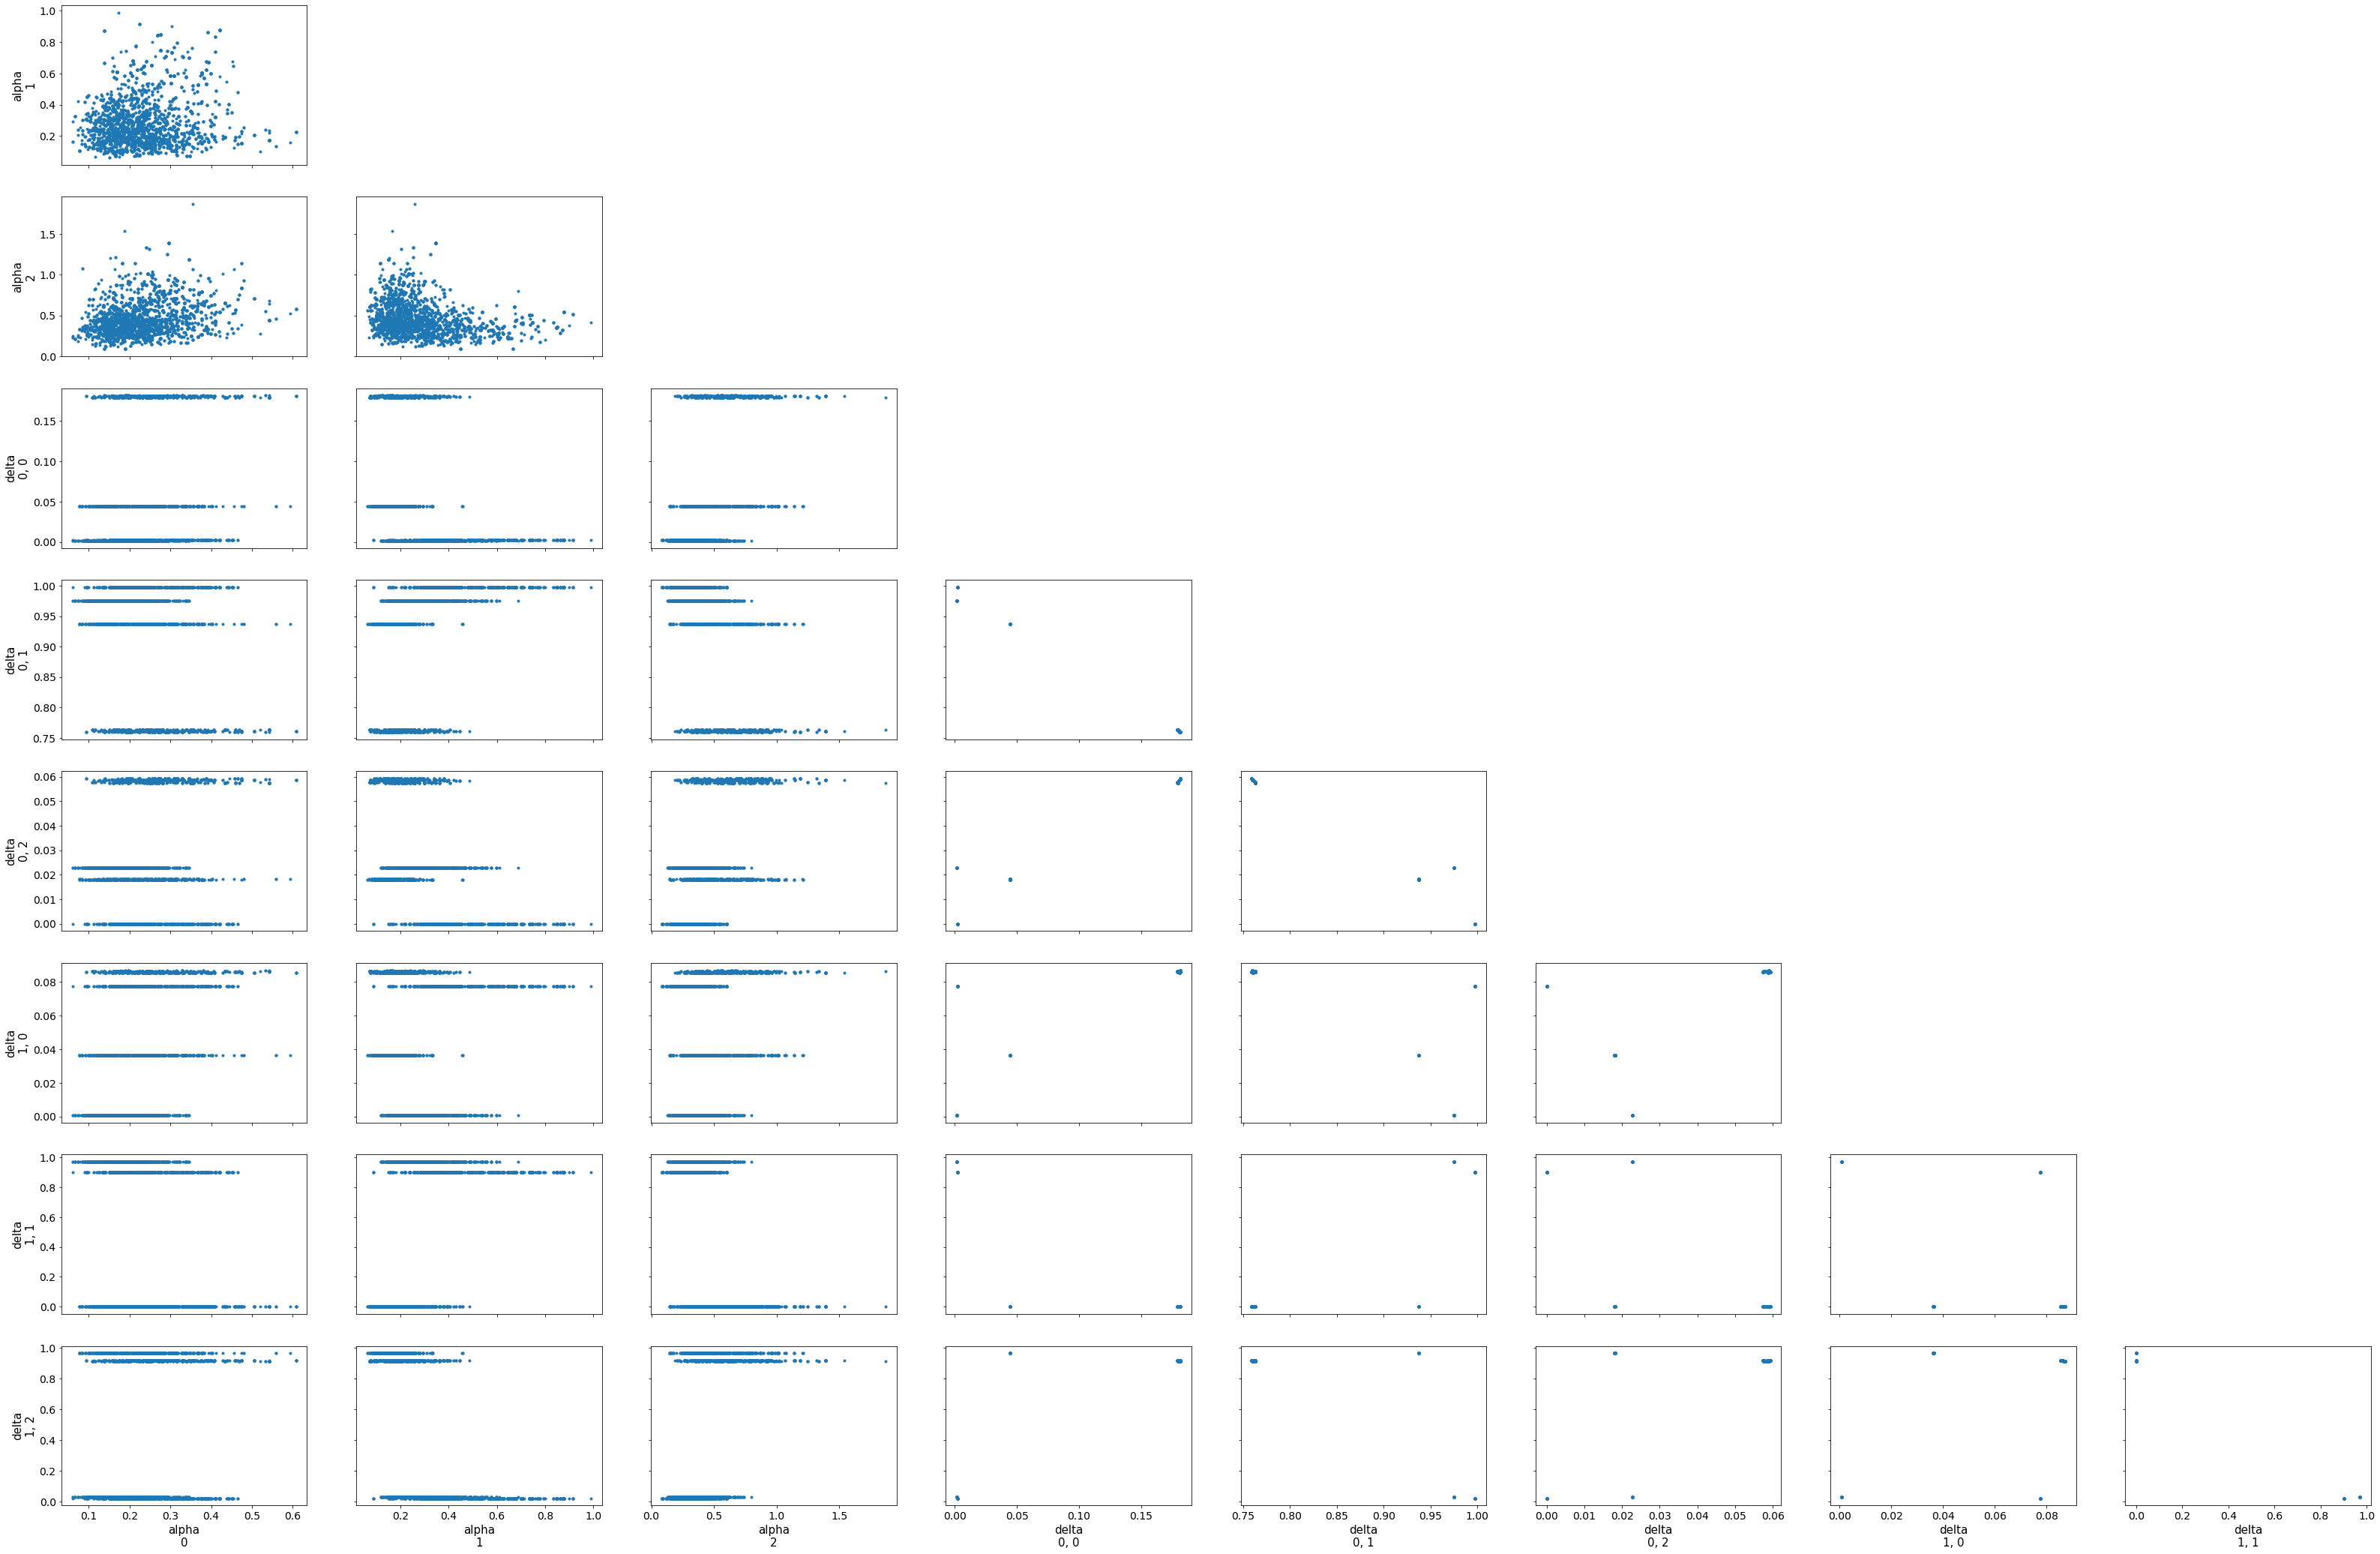

In [131]:
with cont_model:
    pm.pairplot(trace);

In [107]:
# with cont_model:
#     pm.traceplot(trace, var_names = ['delta', 'y_anchors']);

In [108]:
with cont_model:
    ppc = pm.sample_posterior_predictive(trace, samples = 100, var_names=["lambda_"])

/home/abuzarmahmood/anaconda3/lib/python3.6/site-packages/pymc3/sampling.py:1691: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


In [109]:
ppc['lambda_'].shape

(100, 10, 100)

In [ ]:
ppc['delta']

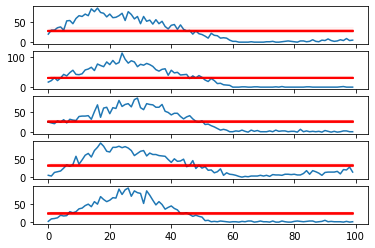

In [110]:
fig,ax = plt.subplots(5)
for i in range(len(ax)):
    ax[i].plot(smooth_dat_vec[i])
    ax[i].plot(ppc['lambda_'][:,i].T, color = 'red', alpha = 0.05);

In [ ]:
observed_data = {'smooth':smooth_dat_vec, 'sharp':sharp_data_vec}
cont_model_traces = {}
for key, vals in observed_data.items():
    with cont_model:
        # Switch out the observed dataset
        pm.set_data({"data": vals})
        
        approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
        trace = approx.sample(draws=samples)
        
        #         trace = pm.sample(step = pm.NUTS(),
        #                 tune = 2000, 
        #                   chains = 8, 
        #                   cores = 8)
        
        cont_model_traces[f'{key}_trace'] = trace 
        cont_model_traces[f'{key}_elbo'] = -approx.hist[-1] 

In [ ]:
with pm.Model() as sharp_model:
    data = pm.Data("data", smooth_dat_vec)
    #     # Finite, but somewhere on the lower end, Beta prior
    #     a_lambda = 2
    #     b_lambda = 5
    #     lambda_latent = pm.Beta('lambda', 
    #                                     a_lambda, b_lambda, 
    #                                     shape = states,
    #                                        testval = [0.1,0.2,0.3])
    
    lambda_latent = pm.Exponential('lambda', 1/np.mean(data.get_value()), 
                                            shape = states,
                                            testval = [0.1,0.2,0.3])

    a = pm.HalfCauchy('a_tau', 3., shape = states - 1)
    b = pm.HalfCauchy('b_tau', 3., shape = states - 1)
    
    even_switches = np.linspace(0,1,states+1)[1:-1]
    tau_latent = pm.Beta('tau_latent', a, b, 
                         testval = even_switches,
                         shape = (states-1)).sort(axis=-1)    
    
    tau = pm.Deterministic('tau', 
            idx.min() + (idx.max() - idx.min()) * tau_latent)
    
    weight_stack = tt.nnet.sigmoid(idx[np.newaxis,:]-tau[:,np.newaxis])
    weight_stack = tt.concatenate([np.ones((1,len(smooth_dat_vec))),weight_stack],axis=0)
    inverse_stack = 1 - weight_stack[1:]
    inverse_stack = tt.concatenate([inverse_stack, np.ones((1,len(smooth_dat_vec)))],axis=0)
    weight_stack = np.multiply(weight_stack,inverse_stack)
    
    lambda_ = pm.Deterministic('lambda_',
                               pm.math.sum(np.multiply(weight_stack,lambda_latent[:,np.newaxis]),axis=0))
    observation = pm.Poisson("obs", lambda_, observed=data)

In [ ]:
pm.model_to_graphviz(sharp_model)

In [ ]:
sharp_model_traces = {}
for key, vals in observed_data.items():    
    with sharp_model:
        # Switch out the observed dataset
        pm.set_data({"data": vals})
        
        approx = pm.fit(n=fit, method=pm.ADVI('full-rank'))
        trace = approx.sample(draws=samples)
        
        #         trace = pm.sample(step = pm.NUTS(),
        #                 tune = 2000, 
        #                   chains = 8, 
        #                   cores = 8)
        
        sharp_model_traces[f'{key}_trace'] = trace 
        sharp_model_traces[f'{key}_elbo'] = -approx.hist[-1] 

In [ ]:
#cont_model_traces

In [ ]:
#sharp_model_traces

In [ ]:
model_types = ['smooth']*2 + ['sharp']*2
elbo_types = ['smooth_elbo', 'sharp_elbo']
data_types = ['smooth', 'sharp']*2
elbos = [cont_model_traces[x] for x in elbo_types[:2]] + [sharp_model_traces[x] for x in elbo_types[:2]]
out_frame = pd.DataFrame(dict(
                model = model_types,
                data_type = data_types,
                elbo_vals = elbos))

In [ ]:
out_frame.sort_values('data_type')

In [ ]:
# plt.plot(approx.hist)
# plt.figure()
# plt.plot(approx.hist[-5000:])

In [ ]:
# with model:
#     pm.summary(trace)

In [ ]:
# with model:
#     pm.traceplot(trace, var_names = ["init_slope", "init_off", "delta", "tau"])

In [ ]:
# with model:
#     pm.pairplot(trace, var_names = ["init_slope", "init_off", "delta", "tau"])

In [ ]:
trace_types = ['smooth_trace','sharp_trace']
with sharp_model:
    #ppc = pm.sample_posterior_predictive(trace, var_names=["init_slope", "init_off", "tau", "lambda_", "obs"])
    for this_type in trace_types:
        lambda_name = f'{this_type}_lambda'
        this_trace = sharp_model_traces[this_type]
        sharp_model_traces[lambda_name] = pm.sample_posterior_predictive(this_trace, samples = 1000, var_names=["lambda_"])
        
with cont_model:
    #ppc = pm.sample_posterior_predictive(trace, var_names=["init_slope", "init_off", "tau", "lambda_", "obs"])
    for this_type in trace_types:
        lambda_name = f'{this_type}_lambda'
        this_trace = cont_model_traces[this_type]
        cont_model_traces[lambda_name] = pm.sample_posterior_predictive(this_trace, samples = 1000, var_names=["lambda_"])

In [ ]:
# plt.hist(ppc['tau'], bins = 50);

In [ ]:
# plt.plot(np.mean(ppc['obs'],axis=0), alpha = 0.7, linewidth = 5, color = 'k');
# plt.plot(binned_data_vec, alpha = 0.7)

In [ ]:
fig,ax = plt.subplots(1,2, figsize = (15,5))
ax[0].plot(smooth_dat_vec, alpha = 0.7);
ax[1].plot(sharp_data_vec, alpha = 0.7);


ax[0].plot(cont_model_traces['smooth_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'red');
ax[0].plot(sharp_model_traces['smooth_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'black');

ax[1].plot(cont_model_traces['sharp_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'red');
ax[1].plot(sharp_model_traces['sharp_trace_lambda']['lambda_'][:20].T, alpha = 0.2, color = 'black');
#plt.plot(ppc['lambda_'][::100,:].T, alpha = 0.2, linewidth = 0.5, color = 'k');


In [ ]:
out_frame.pivot(index = 'model', columns = 'data_type', values = 'elbo_vals')[['smooth','sharp']]

In [ ]:
# print(f" Actual slope : {init_slope}, Inferred slope : {np.round(np.median(trace['init_slope']),3)}")
# print(f" Actual offset : {init_offset}, Inferred offset : {np.round(np.median(trace['init_off']),3)}")
# print(f" Actual delta : {act_delta}, Inferred delta : {np.round(np.median(trace['delta'],axis=0),3)}")
# print(f" Actual cps : {(cps/x.max())*len(x)}, Inferred delta : {np.round(np.median(trace['tau'],axis=0),3)}")